In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
random.seed(43)
import os
from glob import glob
from pathlib import Path
import xmltodict
from traffic_cams.util import bbox_to_target_offsets, iou, targets_to_results, plot_results
from traffic_cams.model import AdvancedObjectDetector, get_basic_loss, fit
from traffic_cams.dataset import ObjectDetectionDataset

In [2]:
import torch
import torch.nn as nn # all the relevant building blocks
import torch.nn.functional as F # functional interfaces for many operations
from torch.utils.data import Dataset, DataLoader # abstract primitives for handling data in pytorch
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.tv_tensors import BoundingBoxes

if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
else:
    print("GPU is not available, using CPU instead")
    device = torch.device("cpu")

GPU is available


In [3]:
classes = ['passenger_car', 'pedestrian', 'bus', 'tram', 'utility_vehicle', 'lorry']
anchors = [] # (K, n_anchros, 2)
for c in classes:
    anchors.append([[0.0530, 0.0304],
                    [0.0957, 0.0671],
                    [0.1610, 0.1170],
                    [0.2561, 0.1953],
                    [0.4059, 0.3488],
                    [0.6490, 0.7201]])  # Anchors relative to image size
anchors = np.array(anchors)
model = AdvancedObjectDetector(len(classes), num_anchors=anchors.shape[1], backbone='efficientnet_b7')
stride = model.get_stride()

model_img_width = int(1280/2)
model_img_height =  int(704/2)

train_dataset = ObjectDetectionDataset('traffic_cams/datasets/dataset_split/train',
                                       model_img_height, model_img_width, 
                                       anchors=anchors,classes=classes, train_transforms=True)
val_dataset = ObjectDetectionDataset('traffic_cams/datasets/dataset_split/val', model_img_height, model_img_width, 
                                     anchors=anchors,classes=classes, train_transforms=False, return_img_id=True)
train_dataset.set_stride(stride)
val_dataset.set_stride(stride)

batch_size=4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

c:\Users\Gordei\Desktop\Univer 2\4 sem\compviz\Project\.venv\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
# Plot training samples
# b=0
# for image_batch, targets_batch in train_loader:

#     targets_batch = targets_batch.detach().cpu()
#     image_batch = image_batch.detach().cpu()

#     fig, axes = plt.subplots(2, 4, figsize=(16, 8))
#     axes = axes.flatten()
#     for i in range(min(batch_size, 8)): 
#         pred = targets_batch[i]
#         img = image_batch[i]
#         ax = axes[i]        
        
#         if isinstance(img, torch.Tensor):
#             img = img.permute(1, 2, 0).numpy()
#         ax.imshow(img)
#         class_ids, confidences, bboxes = targets_to_results(pred, anchors, len(classes),
#                                             stride=stride, 
#                                             model_h = model_img_height, 
#                                             model_w = model_img_width, 
#                                             H=model_img_height, 
#                                             W=model_img_width)                        
#         plot_results(ax, class_ids, confidences, bboxes)
#     fig.tight_layout()
#     if b == 2:
#         break
#     b += 1

In [4]:
model = model.to(device)
model.train()  # Set the model to training mode

#state_dict = torch.load('traffic_cams/checkpoints/best_efficennet_b7_9ep.pth', map_location=torch.device('cpu'))
#model.load_state_dict(state_dict['model_state_dict'])
#history = state_dict['history']

compute_loss = get_basic_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=0.0001)
history = fit(model, 
              optimizer, 
              compute_loss, 
              train_loader, 
              val_loader, 
              5, 
              anchors=anchors, 
              stride=stride, 
              model_img_height=model_img_height, 
              model_img_width=model_img_width,classes=classes, 
              device=device,
              #history=history,
              checkpoint_dir='traffic_cams/checkpoints', 
              model_name='efficennet_b7_v2')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0001)
history = history = fit(model, 
              optimizer, 
              compute_loss, 
              train_loader, 
              val_loader, 
              35, 
              anchors=anchors, 
              stride=stride, 
              model_img_height=model_img_height, 
              model_img_width=model_img_width,classes=classes, 
              device=device,
              history=history,
              checkpoint_dir='traffic_cams/checkpoints', 
              model_name='efficennet_b7_v2')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.00005)
history = history = fit(model, 
              optimizer, 
              compute_loss, 
              train_loader, 
              val_loader, 
              20, 
              anchors=anchors, 
              stride=stride, 
              model_img_height=model_img_height, 
              model_img_width=model_img_width,classes=classes, 
              device=device,
              history=history,
              checkpoint_dir='traffic_cams/checkpoints', 
              model_name='efficennet_b7_v2')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.00001)
history = history = fit(model, 
              optimizer, 
              compute_loss, 
              train_loader, 
              val_loader, 
              20, 
              anchors=anchors, 
              stride=stride, 
              model_img_height=model_img_height, 
              model_img_width=model_img_width,classes=classes, 
              device=device,
              history=history,
              checkpoint_dir='traffic_cams/checkpoints', 
              model_name='efficennet_b7_v2')

Saving checkpoint! mAP=0.00013221059333432713
Epoch 1, Loss: 1059486782808.1144, Val loss: 3.609587949514389, 'Val MAP@0.5: 0.00013221059333432713'
Epoch 2, Loss: 2.0758021781841913, Val loss: 2.352883438269297, 'Val MAP@0.5: 0.00011172571836704725'
Saving checkpoint! mAP=0.0003592953550705653
Epoch 3, Loss: 1.9761491604149342, Val loss: 1.7551858186721803, 'Val MAP@0.5: 0.0003592953550705653'
Epoch 4, Loss: 2.0532006194194157, Val loss: 1.7484100490808487, 'Val MAP@0.5: 0.0002298008947198684'
Epoch 5, Loss: 2.0035328790545464, Val loss: 1.91367915670077, 'Val MAP@0.5: 0.00024326175737809293'
Saving checkpoint! mAP=0.012669214909397564
Epoch 1, Loss: 1.3055395908653735, Val loss: 1.035372339685758, 'Val MAP@0.5: 0.012669214909397564'
Saving checkpoint! mAP=0.021429830366661438
Epoch 2, Loss: 0.9996657972534497, Val loss: 0.8108939965565999, 'Val MAP@0.5: 0.021429830366661438'
Saving checkpoint! mAP=0.038486431199472766
Epoch 3, Loss: 0.8860963257650535, Val loss: 0.7411354362964631, 'V

IndexError: index 20 is out of bounds for dimension 1 with size 20

In [ ]:
checkpoint = {
    'history': history,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    # 'loss': loss,  # If you want to store the last loss value
}
torch.save(checkpoint, 'traffic_cams/checkpoints/last_efficennet_b7_70ep.pth')

In [ ]:
from traffic_cams.non_max_suppression import nms_xywh
b = 0
for image_batch, targets_batch in val_loader:
    model.eval
    # only feedforward pass
    val_preds = model(image_batch.to(device))
    val_preds = val_preds.detach().cpu()
    targets_batch = targets_batch.detach().cpu()
    image_batch = image_batch.detach().cpu()
    # save predictions to later be able to work with them|
    # print(anchors)
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    for i in range(min(batch_size, 8)): 
        pred = val_preds[i]
        #pred = targets_batch[i+2]
        img = image_batch[i]
        ax = axes[i]        
        
        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).numpy()
        ax.imshow(img)
        class_ids, confidences, bboxes = targets_to_results(pred, anchors, len(classes), 
                                                            stride=stride,
                                                            model_h = model_img_height, 
                                                            model_w = model_img_width, 
                                                            H=model_img_height, 
                                                            W=model_img_width)
        
        class_ids, confidences, bboxes = nms_xywh(class_ids, confidences, bboxes, score_threshold=0.9, iou_threshold=0.2)                            
        plot_results(ax, class_ids, confidences, bboxes)
    if b == 5:
        break
    b += 1

In [ ]:
checkpoint_name = 'last_efficennet_b7_70ep'
state_dict = torch.load(f'traffic_cams/checkpoints/b7_v1/{checkpoint_name}.pth', map_location=torch.device('cpu'))
model.load_state_dict(state_dict['model_state_dict'], strict=True)
model.eval()
history = state_dict

In [40]:

from traffic_cams.non_max_suppression import nms_xywh
import pandas as pd
test_img_paths = glob("traffic_cams/datasets/test_resized/images/*.jpg")
transform = transforms.Compose([
    transforms.Resize((model_img_height, model_img_width)),
    transforms.ToTensor()
])
model.to(device)
#model.eval()
out_data = {'image_id':[], 
            'confidence':[],
            'class_name':[],
            'x_min':[],
            'y_min':[],
            'x_max':[],
            'y_max':[]}
for i in range(len(test_img_paths)):
    path = test_img_paths[i]
    img_id = Path(path).stem
    image = Image.open(path,mode='r') 
    transf_image = transform(image).unsqueeze(0).to(device)
    pred_targets = model.forward(transf_image).cpu().detach()
    class_ids, confidences, bboxes = targets_to_results(pred_targets[0], anchors, len(classes), stride=stride,
                                    model_h=model_img_height, model_w=model_img_width, H=720, W=1280)
    class_ids, confidences, bboxes = nms_xywh(class_ids, confidences, bboxes, score_threshold=0.25, iou_threshold=0.2)
    for i in range(len(class_ids)):
        class_id = class_ids[i]
        conf = confidences[i]
        x, y, w, h = bboxes[i]
        class_id = int(class_id)
        out_data['image_id'].append(img_id)
        out_data['confidence'].append(conf)
        out_data['class_name'].append(classes[class_id])
        out_data['x_min'].append(x-w/2)
        out_data['y_min'].append(y-h/2)
        out_data['x_max'].append(x+w/2)
        out_data['y_max'].append(y+h/2)
        
df = pd.DataFrame(out_data)
df.to_csv(f'traffic_cams/{checkpoint_name}@025_1.csv', index_label='ID', index=True)

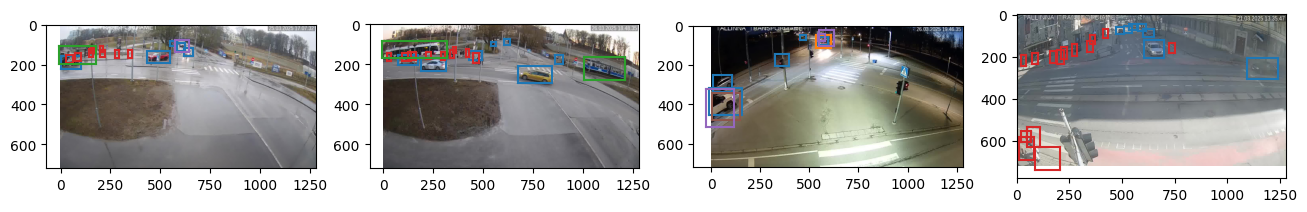

In [41]:
from traffic_cams.non_max_suppression import nms_xywh
transform = transforms.Compose([
    transforms.Resize((model_img_height, model_img_width)),
    transforms.ToTensor()
])

fig, axes = plt.subplots(1, 4, figsize=(16, 8))
test_img_paths = glob("traffic_cams/datasets/dataset_split/val/images/*.jpg")
for i in range(4):
    ax = axes[i]
    j = random.randint(0, len(test_img_paths)-1)
    path = test_img_paths[j]
    img_id = Path(path).stem
    image = Image.open(path,mode='r') 
    transf_image = transform(image).unsqueeze(0).to(device)
    pred_targets = model.forward(transf_image).cpu().detach()
    #print(pred_targets.shape)
    class_ids, confidences, bboxes = targets_to_results(pred_targets[0], anchors, len(classes), stride=stride,
                                model_h=model_img_height, model_w=model_img_width, H=720, W=1280)
    class_ids, confidences, bboxes = nms_xywh(class_ids, confidences, bboxes, score_threshold=0.25, iou_threshold=0.2)
    
    #img=transf_image[0].cpu()
    img = image
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).numpy()
    ax.imshow(img)
    plot_results(ax, class_ids, confidences, bboxes)

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
competition = "object-detection-from-traffic-cams"          
submission_file = "traffic_cams/submission_@0.9.csv"  
submission_message = "Submission test"
api.competition_submit(submission_file, submission_message, competition)